In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from household_package.clean import clean_data

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from google.cloud import bigquery
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [26]:
#Sourcing
columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS", 
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP", 
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH"]

In [27]:
df = pd.read_csv("https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v6.csv", usecols=columns)

In [28]:
TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",4: "Appartment_small" ,5: "Appartment_big"}
YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69", 4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09", 8:"2010-15", 9:"2016-20" }
WALLTYPE_map = {1:"Brick",2:"Wood",3:"Siding",4:"Stucco",5:"Shingle",6:"Stone",7:"Concrete",99:"Other"}
ROOFTYPE_map = {1 : "Ceramic", 2 : "Wood", 3 : "Metal", 4: "Slate", 5: "Shingle", 6: "Concrete", 99: "Other", -2:"Other"}
EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
              5: "Electric_units", 7: "Room_heater", 8 : "Wood", 10:"Electric_heater", 99:"Other", -2:"Other"}

dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, WALLTYPE_map, ROOFTYPE_map, EQUIPM_map]
columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "WALLTYPE", "ROOFTYPE", "EQUIPM"]

In [29]:
for x , y in zip(dics_transform,columns_to_transform):
    df[y] = df[y].map(x)

In [30]:
#Create total bathrooms
df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

In [31]:
#Create variable total computers
df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

In [32]:
#Create variable total lamps
df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

In [36]:
df["STORIES"] = df["STORIES"].replace(-2,1)
df["STORIES"] = df["STORIES"].replace(5,2)

In [37]:
features_imputer2 = ['SWIMPOOL',  'NUMPORTEL', 'SOLAR']
features_imputer4 = ['SMARTMETER']
to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
ohe = OneHotEncoder(sparse_output=False)

preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2),
                                              ('imputer_4',imputer_4, features_imputer4),
                                              ('ohe', ohe, to_ohe_encode)], 
                                                remainder = "passthrough")

preprocessor.fit(df)
#pd.DataFrame(preprocessor.fit_transform(df), columns = preprocessor.get_feature_names_out)

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputer_2',
                                 SimpleImputer(fill_value=0, missing_values=-2,
                                               strategy='constant'),
                                 ['SWIMPOOL', 'NUMPORTEL', 'SOLAR']),
                                ('imputer_4',
                                 SimpleImputer(fill_value=0, missing_values=-4,
                                               strategy='constant'),
                                 ['SMARTMETER']),
                                ('ohe', OneHotEncoder(sparse_output=False),
                                 ['REGIONC', 'state_name', 'BA_climate',
                                  'TYPEHUQ', 'YEARMADERANGE', 'WALLTYPE',
                                  'ROOFTYPE', 'WINDOWS', 'EQUIPM'])])

In [38]:
cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

In [39]:
df2 = pd.DataFrame(preprocessor.transform(df), columns = cols)

In [40]:
for x in df2.columns:
    print(x)

SWIMPOOL
NUMPORTEL
SOLAR
SMARTMETER
REGIONC_MIDWEST
REGIONC_NORTHEAST
REGIONC_SOUTH
REGIONC_WEST
state_name_Alabama
state_name_Alaska
state_name_Arizona
state_name_Arkansas
state_name_California
state_name_Colorado
state_name_Connecticut
state_name_Delaware
state_name_District of Columbia
state_name_Florida
state_name_Georgia
state_name_Hawaii
state_name_Idaho
state_name_Illinois
state_name_Indiana
state_name_Iowa
state_name_Kansas
state_name_Kentucky
state_name_Louisiana
state_name_Maine
state_name_Maryland
state_name_Massachusetts
state_name_Michigan
state_name_Minnesota
state_name_Mississippi
state_name_Missouri
state_name_Montana
state_name_Nebraska
state_name_Nevada
state_name_New Hampshire
state_name_New Jersey
state_name_New Mexico
state_name_New York
state_name_North Carolina
state_name_North Dakota
state_name_Ohio
state_name_Oklahoma
state_name_Oregon
state_name_Pennsylvania
state_name_Rhode Island
state_name_South Carolina
state_name_South Dakota
state_name_Tennessee
state_na

In [17]:
to_scale = ["TELLWORK","NUMPORTEL", "STORIES",
            "SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM", "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

In [18]:
import matplotlib.pyplot as plt

In [19]:
df2[to_scale].apply(lambda x : x.unique())

TELLDAYS                [0.0, 7.0, 5.0, 6.0, 2.0, 1.0, 4.0, 3.0]
NUMPORTEL      [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0, 9.0, ...
STORIES                                     [1.0, 2.0, 3.0, 4.0]
SQFTEST        [2100.0, 590.0, 900.0, 800.0, 3010.0, 1200.0, ...
TOTROOMS       [8.0, 3.0, 4.0, 9.0, 5.0, 7.0, 6.0, 14.0, 11.0...
NUMFRIG        [2.0, 1.0, 0.0, 3.0, 4.0, 5.0, 7.0, 6.0, 9.0, ...
MICRO                                       [1.0, 0.0, 2.0, 3.0]
TVCOLOR        [3.0, 1.0, 2.0, 5.0, 4.0, 0.0, 6.0, 10.0, 7.0,...
NHSLDMEM                     [2.0, 1.0, 4.0, 6.0, 5.0, 3.0, 7.0]
TOTAL_BATH                        [3.0, 1.0, 2.0, 4.0, 5.0, 6.0]
TOTAL_COMP     [1.0, 0.0, 3.0, 5.0, 4.0, 2.0, 6.0, 8.0, 10.0,...
TOTAL_LIGHT    [17.0, 4.0, 6.0, 13.0, 23.0, 10.0, 8.0, 5.0, 3...
dtype: object

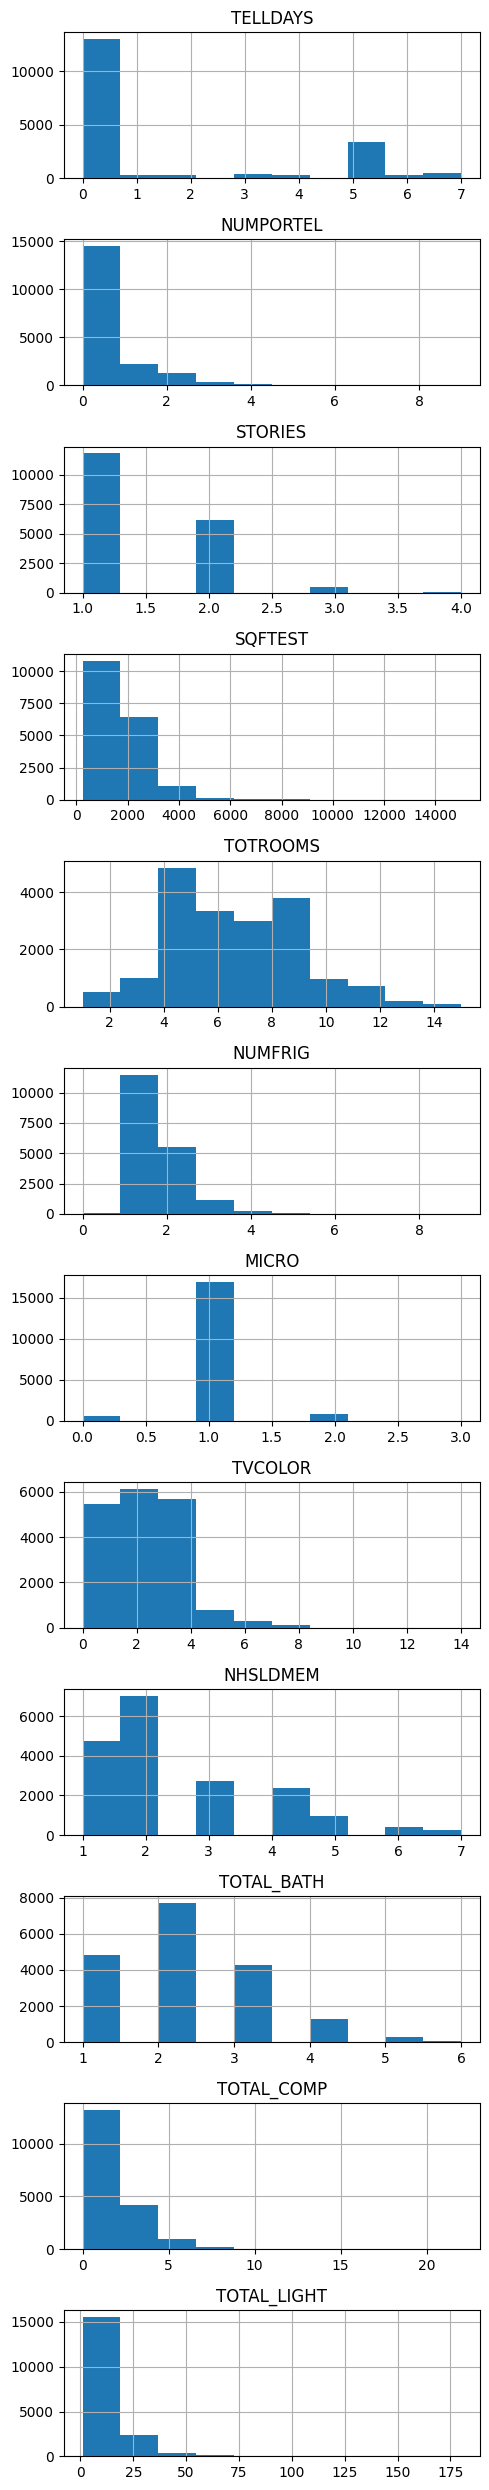

In [20]:
fig, axs = plt.subplots(len(to_scale), figsize=(5, 25))
for n, col in enumerate(to_scale):
    df2[col].hist(ax=axs[n])
    axs[n].set_title(col)
plt.tight_layout()


In [43]:
df2["KWH"]

0        12521.48
1         5243.05
2         2387.64
3         9275.07
4         5869.70
           ...   
18491     5638.33
18492     4425.20
18493    15121.25
18494    18604.35
18495    19818.82
Name: KWH, Length: 18496, dtype: float64

In [ ]:
df2.drop()

In [45]:
df2.drop("KWH", axis = 1)

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC_MIDWEST,REGIONC_NORTHEAST,REGIONC_SOUTH,REGIONC_WEST,state_name_Alabama,state_name_Alaska,...,DRYER,TVCOLOR,TELLWORK,HEATHOME,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,0.0,1.0,1.0,2.0,2100.0,3.0,1.0,17.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,590.0,1.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,900.0,1.0,0.0,6.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,0.0,1.0,1.0,2.0,2100.0,3.0,1.0,17.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,1.0,1.0,2.0,800.0,1.0,3.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,1.0,4.0,1200.0,3.0,4.0,29.0
18492,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,1.0,1.0,1.0,1530.0,1.0,1.0,4.0
18493,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,1.0,4.0,1500.0,2.0,2.0,15.0
18494,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3.0,0.0,1.0,1.0,1.0,3000.0,4.0,1.0,6.0


In [47]:
df2["KWH"].describe()

count     18496.000000
mean      10848.818722
std        7111.765122
min          42.010000
25%        5921.970000
50%        9346.435000
75%       14155.327500
max      184101.840000
Name: KWH, dtype: float64